<a href="https://colab.research.google.com/github/leejs209/MesaABM/blob/master/MesaABM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python 및 행위자 기반 모형을 통한 교내 사회적 거리두기 정책의 효과 분석


##  1.  준비

필요한 패키지 설치, 관련 설정 및 import

In [1]:
!pip install mesa

In [2]:
%matplotlib inline

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from random import shuffle
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import glob
import os
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
 %config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
rc('font', family='NanumBarunGothic') 
font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [5]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  2.  모델 구현

####  각 스텝에서 S,E,I,R 상태의 행위자의 수를 제시하는 함수 정의  

In [6]:
def s_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "S":
            cnt += 1
    return cnt


def i_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "I":
            cnt += 1
    return cnt


def r_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "R":
            cnt += 1
    return cnt

def e_count(model):
    cnt = 0
    for agent in model.schedule.agents:
        if agent.status == "E":
            cnt += 1
    return cnt

def affected(model):
    return model.N - s_count(model)


####  Student 및 School Class (모델) 구현

In [7]:
class Student(Agent):
    """ A Student that moves depending on the time, space, and other students"""

    def __init__(self, unique_id, group_no, status, infection_duration, model, dinner):
        super().__init__(unique_id, model)
        self.group_no = group_no
        self.reside_no = group_no
        self.status = status
        self.infected_timeleft = infection_duration
        self.infection_duration = infection_duration
        self.exposed_timeleft = self.model.exposed_duration
        self.dinner = dinner

    def meal_normal(self):
        if len(self.model.order) != 0:
            t = self.model.order[self.unique_id - 1]
        else:
            t = self.unique_id
        k = ((t - 1) // 5) % 46
        if k % 2 == 0:
            xpos = k * 3 / 2 + 1
        else:
            xpos = (k * 3 + 1) / 2
        ypos = (t - 1) % 5 + 31 + 6 * ((t - 1) // 460)
        self.model.grid.move_agent(self, (int(xpos), int(ypos)))

    def meal_distanced(self):
        k = self.unique_id - 1
        layer = k // 230
        t = k % 5
        if t == 0:
            xpos = 3 * (k % 230) // 5 + 1
            ypos = 31 + layer * 6
        elif t == 1:
            xpos = 3 * (k % 230 - 1) / 5 + 1
            ypos = 33 + layer * 6
        elif t == 2:
            xpos = 3 * (k % 230 - 2) / 5 + 1
            ypos = 35 + layer * 6
        elif t == 3:
            xpos = 3 * (k % 230 - 3) / 5 + 2
            ypos = 32 + layer * 6
        else:
            xpos = 3 * (k % 230 - 4) / 5 + 2
            ypos = 34 + layer * 6
        self.model.grid.move_agent(self, (int(xpos), int(ypos)))

    def move_to_group(self, group_no):
        x1 = ((group_no - 1) % 14) * 10 + 1
        x2 = x1 + 8

        y1 = ((group_no - 1) // 14) * 10 + 1
        y2 = y1 + 8

        new_pos = (self.random.randint(x1, x2), self.random.randint(y1, y2))
        self.model.grid.move_agent(self, new_pos)

    def move_within_bound(self, group_no):
        x1 = ((group_no - 1) % 14) * 10 + 1
        x2 = x1 + 8

        y1 = ((group_no - 1) // 14) * 10 + 1
        y2 = y1 + 8

        # if not x1 <= self.pos[0] <= x2 or not y1 <= self.pos[1] <= y2:
        #    print("Agent is told to move in group's bound without being in it first.", x1, self.pos[0], x2, y1, self.pos[1], y2)

        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius=1)

        bounded_steps = []
        for x in possible_steps:
            if x1 <= x[0] <= x2 and y1 <= x[1] <= y2:
                bounded_steps.append(x)

        if len(bounded_steps) == 0:
            return

        new_pos = self.random.choice(bounded_steps)
        self.model.grid.move_agent(self, new_pos)

    def spread_infection(self, multiplier):
        # Spread infection only when self is Infected or Exposed
        if self.status != "I" and self.status != "E":
            return

        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) <= 1:
            return

        if self.status == "I":
            for x in cellmates:
                if x.status == "S" and self.random.random() <= self.model.infection_prob_per_contact * multiplier:
                    x.status = "E"
        else:
            for x in cellmates:
                if x.status == "S" and self.random.random() <= self.model.exposed_infection_prob_per_contact * multiplier:
                    x.status = "E"

    def recovery_countdown(self):
        if self.status == "E":
            if self.exposed_timeleft > 0:
                self.exposed_timeleft -= 1
            else:
                self.status = "I"
                self.exposed_timeleft = self.model.exposed_duration

        if self.status == "I":
            if self.infected_timeleft > 0:
                self.infected_timeleft -= 1
            else:
                self.status = "R"
                self.infected_timeleft = self.infection_duration
                
    def step(self):
        #step_no는 1, 2, ...
        #홀수반 = 1학년, 짝수반 = 2학년
        if self.model.split_opening and (((self.model.step_no - 1) // len(self.model.timetable)) // 5) % 2 == 0: #홀수주
            open_schedule = 23
        elif self.model.split_opening and (((self.model.step_no - 1) // len(self.model.timetable)) // 5) % 2 == 1: #짝수주
            open_schedule = 13
        else:
            open_schedule = 123 #격주등교 안함
        inschool = open_schedule == 123 or (open_schedule == 13 and not self.group_no in range(2,29,2)) or (open_schedule == 23 and not self.group_no in range(1,29,2))
        m = self.model.timetable[(self.model.step_no - 1)% len(self.model.timetable)]

        #격주등교시 미등교 학년 비활성
        if self.model.split_opening and self.group_no in range(2,29,2) and open_schedule == 13:
            self.model.grid.move_agent(self, (139, 60))
        elif self.model.split_opening and self.group_no in range(1,29,2) and open_schedule == 23:
            self.model.grid.move_agent(self, (139, 60))
        #등교하는 경우
        elif inschool:
            if m == 'meal':
                if self.model.meal_distanced == True:
                    self.meal_distanced()
                    self.spread_infection(self.model.restaurant_multiplier)
                else:
                    self.meal_normal()
                    self.spread_infection(self.model.restaurant_multiplier)

            elif m == 'meal_cont':
                self.spread_infection(self.model.restaurant_multiplier)

            elif m == 'recess':
                #교실 간 이동 확률
                if self.random.random() < self.model.visit_prob_per_person:
                    if not open_schedule == 23 and self.group_no in range(1,29,2): # 등교한 1학년
                        self.reside_no = self.random.randrange(1,29,2)
                        self.move_to_group(self.reside_no)
                        self.spread_infection(1)
                    elif not open_schedule == 13 and self.group_no in range(2,29,2): # 등교한 2학년
                        self.reside_no = self.random.randrange(2, 29, 2)
                        self.move_to_group(self.reside_no)
                        self.spread_infection(1)
                    elif self.group_no in range(29,43): # 3학년
                        self.reside_no = self.random.randint(29, 42)
                        self.move_to_group(self.reside_no)
                        self.spread_infection(1)
                    else: #미등교자 무시
                        pass
                else:
                    #이동 안하면 자기 반으로 배치
                    self.reside_no = self.group_no
                    self.move_to_group(self.group_no)
                    self.spread_infection(1)

            elif m == 'recess_cont':
                self.move_within_bound(self.reside_no)
                if inschool:
                    self.spread_infection(1)

            elif m == 'dinner' and self.dinner == True:
                if self.model.meal_distanced == True and inschool:
                    self.meal_distanced()
                    self.spread_infection(self.model.restaurant_multiplier)
                elif inschool:
                    self.meal_normal()
                    self.spread_infection(self.model.restaurant_multiplier)
                else:
                    pass

            elif m == 'dinner' and self.dinner == False:
                self.model.grid.move_agent(self, (139,60))

            elif m == 'dinner_cont':
                if self.dinner == True and inschool:
                    self.spread_infection(self.model.restaurant_multiplier)
        else:
            print("This error shouldn't happen.")
        self.recovery_countdown()

In [8]:
class SchoolModel(Model):
    def __init__(self, N, N_per_group, width, height, initial_num_infected,
                 infection_duration, exposed_duration, infection_prob_per_contact, exposed_infection_prob_per_contact,
                 restaurant_multiplier, visit_prob_per_person,
                 meal_random, meal_distanced, timetable, dinner_percentage, split_opening
                 ):

        super().__init__()
        self.N = N
        self.i_count = 0
        self.e_count = 0
        self.s_count = self.N
        self.r_count = 0
        self.step_no = 0
        self.N_per_group = N_per_group
        self.timetable = timetable
        self.infection_duration = infection_duration * len(self.timetable)
        self.exposed_duration = exposed_duration * len(self.timetable)
        self.infection_prob_per_contact = infection_prob_per_contact
        self.restaurant_multiplier = restaurant_multiplier
        self.visit_prob_per_person = visit_prob_per_person
        self.meal_random = meal_random
        self.meal_distanced = meal_distanced
        self.dinner_percentage = dinner_percentage
        self.split_opening = split_opening
        self.exposed_infection_prob_per_contact = exposed_infection_prob_per_contact

        order = []
        if self.meal_random:
            for i in range(1, self.N + 1):
                order.append(i)
            shuffle(order)

        self.order = order
        # self.grid = ContinuousSpace(width, height, True)
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)

        if self.split_opening:
            initial_infected = [self.random.randrange(14*25, self.N) for _ in range(initial_num_infected)]
        else:
            initial_infected = [self.random.randrange(0, self.N) for _ in range(initial_num_infected)]

        for t in range(0, self.N):
            # (self, unique_id, group_no, status, infection_duration, model)
            group_no = t // N_per_group + 1

            x1 = ((group_no - 1) % 14) * 10 + 1
            x2 = x1 + 8

            y1 = ((group_no - 1) // 14) * 10 + 1
            y2 = y1 + 8

            a = Student(t + 1, group_no, "S", self.infection_duration, self, False)

            if t in initial_infected:
                a.status = "I"

            if self.random.random() < self.dinner_percentage:
                a.dinner = True

            self.schedule.add(a)

            self.grid.place_agent(a, (self.random.randint(x1, x2), self.random.randint(y1, y2)))

        self.datacollector = DataCollector(
            model_reporters={"Susceptible": s_count, "Infected": i_count, "Recovered": r_count, "Exposed": e_count},
            agent_reporters={}
        )

        self.affected_collector = DataCollector(
            model_reporters={"Affected": affected},
            agent_reporters={}
        )

    def step(self):
        """ Advance the model by one step."""
        self.step_no += 1
        self.i_count = i_count(self)
        self.s_count = s_count(self)
        self.e_count = e_count(self)
        self.r_count = r_count(self)

        self.datacollector.collect(self)
        self.schedule.step()

####  `do_experiment`  함수 구현
목적:  모델 실행 한번 한번의 출력값을 적절한 이름의 csv 파일으로 출력해준다.

In [9]:
timetable_normal = [
    'recess',
    'recess_cont',
    'recess',
    'recess_cont',
    'recess',
    'recess_cont',
    'recess',
    'recess_cont',
    'recess',
    'recess_cont',
    'recess',
    'recess_cont',
    'meal',
    'meal_cont',
    'meal_cont',
    'recess',
    'recess_cont',
    'recess_cont',
    'recess_cont',
    'recess_cont',
    'recess_cont',
    'recess',
    'recess_cont',
    'recess',
    'recess_cont'
]

timetable_extra = timetable_normal + [
    'recess',
    'recess_cont',
    'recess',
    'recess_cont',
    'dinner',
    'dinner_cont',
    'dinner_cont',
    'recess',
    'recess_cont',
    'recess_cont',
    'recess_cont',
    'recess_cont',
    'recess_cont',
    'recess_cont'
]

RESULT_DIR = "/content/drive/My Drive/Colab Notebooks/MesaABM/result/"  # 출력 폴더. "/"로 끝나야 한다.
STUDENT_NO = 1050  # 총 학생 수

def do_experiment(EXPERIMENT_NAME, model):
    """ RESULT_DIR/csv/EXPERIMENT_NAME라는 폴더에 실험 실행 결과의 csv 파일을 저장한다."""
  

    datetime_string = str(datetime.datetime.now().strftime('%m-%d %H-%M-%S'))
    start = time.time()  # 모델 실행에 걸리는 시간을 측정한다.
    model.step()
    while model.i_count != 0 or model.e_count != 0:  # 감염자 또는 잠복기가 0명이 될 때까지 측정한다.
        model.step()

    result = model.datacollector.get_model_vars_dataframe()
    # 실험 실행 후 결과를 그래프로 그려 RESULT_DIR에 이미지 파일로 저장한다.
    # result.plot()
    # plt.xlim(0, 2000)
    # plt.savefig(RESULT_DIR + EXPERIMENT_NAME + datetime_string + '.png', bbox_inches='tight')
    # plt.close()

    # csv 파일로 실험 결과를 출력한다.
    if not os.path.exists(RESULT_DIR):
        os.mkdir(RESULT_DIR)
    if not os.path.exists(RESULT_DIR + 'csv'):
        os.mkdir(RESULT_DIR + 'csv')
    if not os.path.exists(RESULT_DIR + 'csv/' + EXPERIMENT_NAME):
        os.mkdir(RESULT_DIR + 'csv/' + EXPERIMENT_NAME)

    result.to_csv(RESULT_DIR + 'csv/' + EXPERIMENT_NAME + '/' + EXPERIMENT_NAME + datetime_string + '.csv')

    # result라는 이름의 Dataframe에서 4개의 column에 대해 7일(7 * 1일당 step 수)이 흐른 후의 값들을 EXPERIMET_NAME.csv에 추가한다.
    # r = '\n'
    #
    # for x in range(4):
    #     r = r + str(result.iloc[7 * len(model.timetable)][x]) + ','
    #
    # r += str(model.step_no) + ','
    # with open(RESULT_DIR + EXPERIMENT_NAME + '.csv', 'a') as f:
    #     f.write(r)
    #     f.close()

    # 소요 시간 출력
    end = time.time()
    print(EXPERIMENT_NAME + ": " + str(end - start) + '초 소요됨')

#### 결과 해석용 함수 정의
`average_IER`: RESULT_DIR/csv에서 인자로 받은 EXPERIMENT_NAME라는 이름을 가진 폴더의 csv 파일들의 평균을 구하여 RESULT_DIR/average에 저장한다.\
`combine_same_hypothesis()`: 여러번 수행한 실험 결과를 한 그래프에 겹쳐서 그린다.\
`combine_averages()`: 여러 가설들의 그래프를 한 그래프로 합쳐서 그린다.

In [10]:
def average_IER(EXPERIMENT_NAME, DAY_LENGTH):
    """ RESULT_DIR/csv에서 인자로 받은 EXPERIMENT_NAME라는 이름을 가진 폴더의 csv 파일들의 평균을 구하여 RESULT_DIR/average에 저장한다."""

    if not os.path.exists(RESULT_DIR + 'average'):
        os.mkdir(RESULT_DIR + 'average')
    # DAY_LENGTH = 25
    # DAY_LENGTH = 37

    # do_experiment에서 출력한 실험의 결과를 모두 불러온다.
    path = RESULT_DIR + 'csv/' + EXPERIMENT_NAME
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df_from_each_file = [pd.read_csv(f) for f in all_files]

    # 불러온 파일 중 첫번째 파일의 column 이름을 적절히 바꾸고 I, R, E에 해당하는 column을 삭제한다.
    # df_from_each_file[0].rename(columns={'Unnamed: 0': 'step'}, inplace=True)
    # result = df_from_each_file[0].drop(['Infected', 'Recovered', 'Exposed'], axis=1)
    # result.rename(columns={'Unnamed: 0': 'step'}, inplace=True)

    # 실험 결과 파일 중 step 수가 가장 짧은 값을 구한다.
    cnt = float('inf')
    for x in df_from_each_file:
        a = len(x.Susceptible.index)
        if a < cnt:
            cnt = len(x.Susceptible.index)

    # 불러온 실험들의 각 행에 대해 (전체 인구 - S값)의 평균을 구하고 k 리스트에 추가한다..
    k = []
    for y in range(1, cnt, DAY_LENGTH):
        r = 0
        a = 0
        for t in df_from_each_file:
            r += STUDENT_NO - t.iloc[y, 1]
            a += 1
        r = r / a
        k.append(r)

    # x축을 경과 시간으로, y축을 (전체 - S)의 인구수의 값으로 하여 Dataframe을 출력한다.
    final = pd.DataFrame(data=k, index=range(cnt // DAY_LENGTH + 1))
    final.to_csv(RESULT_DIR + 'average/' + EXPERIMENT_NAME + '_infected_average.csv')

    final.plot()
    plt.xlim(0, 40)
    plt.show()
    # plt.savefig(RESULT_DIR + 'average/infected_average_xlim.png', bbox_inches='tight')
    plt.close()


In [11]:
def combine_same_hypothesis(EXPERIMENT_NAME):
    path = RESULT_DIR + 'csv/' + EXPERIMENT_NAME
    all_files = glob.glob(os.path.join(path, "*.csv"))

    df_from_each_file = [pd.read_csv(f) for f in all_files]

    # 첫번쨰 파일을 탬플릿으로
    final = df_from_each_file[0]
    final.drop(["Infected", 'Recovered', 'Exposed'], axis=1, inplace=True)
    final.rename(columns={'Susceptible': os.path.basename(list(all_files)[0])}, inplace=True)

    # 여러 실험을 한 dataframe으로 합치기
    for t in range(1, len(df_from_each_file)):
        x = df_from_each_file[t]
        x.drop(["Infected", 'Recovered', 'Exposed'], axis=1, inplace=True)
        x.rename(columns={'Susceptible': os.path.basename(list(all_files)[t])}, inplace=True)
        
        t += 1
        final = pd.merge(final, x, on='Unnamed: 0')

    # 필요없는 step column 지우기
    final.drop(['Unnamed: 0'], axis=1, inplace=True)

    if not os.path.exists(RESULT_DIR + 'total'):
        os.mkdir(RESULT_DIR + 'total')
    final.to_csv(RESULT_DIR + 'total/' + EXPERIMENT_NAME + '_EIR_combined.csv')
    final.plot(legend=None)
    plt.xlim(0, 2000)
    # plt.savefig(RESULT_DIR + 'total/' + EXPERIMENT_NAME + '_EIR_combined_xlim.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [12]:
def combine_averages():
    """ 실험 결과를 평균처리 한 파일을 하나의 dataframe으로 합치고 그래프를 출력한다. """
    # average 폴더의 csv 파일을 모두 불러온다
    path = RESULT_DIR + 'average'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df_from_each_file = [pd.read_csv(f) for f in all_files]

    # average 폴더에서 불러온 첫 파일을 템플릿으로 삼고, csv 파일 이름을 column 이름으로 한다.
    final = df_from_each_file[0]
    final.rename(columns={'0': os.path.basename(list(all_files)[0])}, inplace=True)

    # average 폴더의 나머지 파일에서 IER 합친 값을 불러온 후 final Dataframe에 추가한다.
    for t in range(1, len(df_from_each_file)):
        x = df_from_each_file[t]
        x.rename(columns={'0': os.path.basename(list(all_files)[t])}, inplace=True)
        t += 1
        final = pd.merge(final, x, on='Unnamed: 0')

    # 마무리 작업으로 step column을 제거한다.
    final.drop(['Unnamed: 0'], axis=1, inplace=True)

    # 최종적으로 합친 값을 출력한다.
    final.to_csv(RESULT_DIR + 'average/infected_average.csv')

    # 그래프로 출력한다.
    final.plot()
    plt.savefig(RESULT_DIR + 'average/infected_average_xlim.png', bbox_inches='tight')
    plt.show()
    plt.close()

##  3.  모델 실행

###  가.  마스크의 효과 확인

####  1)  β값 

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('대조군', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

###  나.  거리두기 정책 비교

In [13]:
no_of_experiment = 50

#### 1) 대조군

In [ ]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('대조군', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

#### 2) 1,2학년 교차 등교를 한다면?
가설 1번

In [16]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('1번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=True))

1번쨰 실험
1번: 23.15008282661438초 소요됨
2번쨰 실험
1번: 20.482379913330078초 소요됨
3번쨰 실험
1번: 22.5394549369812초 소요됨
4번쨰 실험
1번: 22.13064694404602초 소요됨
5번쨰 실험
1번: 23.3794367313385초 소요됨
6번쨰 실험
1번: 25.660886526107788초 소요됨
7번쨰 실험
1번: 22.62425947189331초 소요됨
8번쨰 실험
1번: 23.13240361213684초 소요됨
9번쨰 실험
1번: 24.16047978401184초 소요됨
10번쨰 실험
1번: 4.072523355484009초 소요됨
11번쨰 실험
1번: 22.83367609977722초 소요됨
12번쨰 실험
1번: 22.444098711013794초 소요됨
13번쨰 실험
1번: 25.677067279815674초 소요됨
14번쨰 실험
1번: 20.47768998146057초 소요됨
15번쨰 실험
1번: 25.23140859603882초 소요됨
16번쨰 실험
1번: 23.69734525680542초 소요됨
17번쨰 실험
1번: 22.90854001045227초 소요됨
18번쨰 실험
1번: 22.271297931671143초 소요됨
19번쨰 실험
1번: 27.614412784576416초 소요됨
20번쨰 실험
1번: 25.383983612060547초 소요됨
21번쨰 실험
1번: 23.171396493911743초 소요됨
22번쨰 실험
1번: 23.047114372253418초 소요됨
23번쨰 실험
1번: 23.44628095626831초 소요됨
24번쨰 실험
1번: 22.195877075195312초 소요됨
25번쨰 실험
1번: 22.937134981155396초 소요됨
26번쨰 실험
1번: 24.811800241470337초 소요됨
27번쨰 실험
1번: 22.28211259841919초 소요됨
28번쨰 실험
1번: 22.408512115478516초 소요됨
29번쨰 실험
1번: 27.044

#### 3) 보충과 야자를 하지 않는다면?
가설 2번

In [17]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('2번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_normal, split_opening=False))

1번쨰 실험
2번: 14.9634370803833초 소요됨
2번쨰 실험
2번: 14.973682641983032초 소요됨
3번쨰 실험
2번: 14.364038228988647초 소요됨
4번쨰 실험
2번: 14.773316144943237초 소요됨
5번쨰 실험
2번: 15.405851125717163초 소요됨
6번쨰 실험
2번: 16.3498375415802초 소요됨
7번쨰 실험
2번: 15.942615270614624초 소요됨
8번쨰 실험
2번: 15.486291408538818초 소요됨
9번쨰 실험
2번: 15.901060342788696초 소요됨
10번쨰 실험
2번: 14.546597957611084초 소요됨
11번쨰 실험
2번: 15.641955375671387초 소요됨
12번쨰 실험
2번: 15.08984923362732초 소요됨
13번쨰 실험
2번: 15.759765386581421초 소요됨
14번쨰 실험
2번: 14.423002243041992초 소요됨
15번쨰 실험
2번: 15.730382442474365초 소요됨
16번쨰 실험
2번: 15.046326637268066초 소요됨
17번쨰 실험
2번: 14.442641735076904초 소요됨
18번쨰 실험
2번: 15.309518575668335초 소요됨
19번쨰 실험
2번: 15.053780555725098초 소요됨
20번쨰 실험
2번: 14.788869857788086초 소요됨
21번쨰 실험
2번: 14.537895679473877초 소요됨
22번쨰 실험
2번: 14.030142545700073초 소요됨
23번쨰 실험
2번: 15.030457019805908초 소요됨
24번쨰 실험
2번: 15.788723945617676초 소요됨
25번쨰 실험
2번: 16.688745975494385초 소요됨
26번쨰 실험
2번: 15.277865648269653초 소요됨
27번쨰 실험
2번: 14.176801204681396초 소요됨
28번쨰 실험
2번: 14.814034461975098초 소요됨
29번쨰 실

#### 4) 교실 간 이동을 금지한다면?
가설 3번

In [18]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('3번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0,
                        meal_random=True, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

1번쨰 실험
3번: 21.49475359916687초 소요됨
2번쨰 실험
3번: 21.012463331222534초 소요됨
3번쨰 실험
3번: 21.320187091827393초 소요됨
4번쨰 실험
3번: 21.23798632621765초 소요됨
5번쨰 실험
3번: 24.10632562637329초 소요됨
6번쨰 실험
3번: 23.59951400756836초 소요됨
7번쨰 실험
3번: 21.051395654678345초 소요됨
8번쨰 실험
3번: 20.609548330307007초 소요됨
9번쨰 실험
3번: 21.03143334388733초 소요됨
10번쨰 실험
3번: 21.271950244903564초 소요됨
11번쨰 실험
3번: 20.99863314628601초 소요됨
12번쨰 실험
3번: 21.425902605056763초 소요됨
13번쨰 실험
3번: 22.190656900405884초 소요됨
14번쨰 실험
3번: 21.214332342147827초 소요됨
15번쨰 실험
3번: 22.190701007843018초 소요됨
16번쨰 실험
3번: 20.332658290863037초 소요됨
17번쨰 실험
3번: 22.670923709869385초 소요됨
18번쨰 실험
3번: 21.134888887405396초 소요됨
19번쨰 실험
3번: 21.625370025634766초 소요됨
20번쨰 실험
3번: 21.775962591171265초 소요됨
21번쨰 실험
3번: 21.68281102180481초 소요됨
22번쨰 실험
3번: 20.57800269126892초 소요됨
23번쨰 실험
3번: 20.4575834274292초 소요됨
24번쨰 실험
3번: 20.410290718078613초 소요됨
25번쨰 실험
3번: 21.86306643486023초 소요됨
26번쨰 실험
3번: 21.43097972869873초 소요됨
27번쨰 실험
3번: 22.134816884994507초 소요됨
28번쨰 실험
3번: 22.476135969161987초 소요됨
29번쨰 실험
3번: 2

#### 5) 급식 순서를 반별로 먹는다면?
가설 4번

In [19]:
for t in range(no_of_experiment):
    print(str(t+1) + "번쨰 실험")
    do_experiment('4번', SchoolModel(N=STUDENT_NO, N_per_group=25, width=140, height=61, initial_num_infected=1,
                        infection_duration=7, exposed_duration=5,
                        infection_prob_per_contact=0.2, exposed_infection_prob_per_contact=0.05,
                        restaurant_multiplier=3, visit_prob_per_person=0.1,
                        meal_random=False, meal_distanced=False, dinner_percentage=0.3,
                        timetable=timetable_extra, split_opening=False))

1번쨰 실험
4번: 20.85551881790161초 소요됨
2번쨰 실험
4번: 21.991474151611328초 소요됨
3번쨰 실험
4번: 21.531293630599976초 소요됨
4번쨰 실험
4번: 22.98015069961548초 소요됨
5번쨰 실험
4번: 24.136600494384766초 소요됨
6번쨰 실험
4번: 23.10523223876953초 소요됨
7번쨰 실험
4번: 21.816879749298096초 소요됨
8번쨰 실험
4번: 21.678093194961548초 소요됨
9번쨰 실험
4번: 21.427506685256958초 소요됨
10번쨰 실험
4번: 21.571983098983765초 소요됨
11번쨰 실험
4번: 24.287420988082886초 소요됨
12번쨰 실험
4번: 25.48295283317566초 소요됨
13번쨰 실험
4번: 21.931509971618652초 소요됨
14번쨰 실험
4번: 20.38461995124817초 소요됨
15번쨰 실험
4번: 23.170918703079224초 소요됨
16번쨰 실험
4번: 20.580265998840332초 소요됨
17번쨰 실험
4번: 22.941633701324463초 소요됨
18번쨰 실험
4번: 21.381385326385498초 소요됨
19번쨰 실험
4번: 23.510841846466064초 소요됨
20번쨰 실험
4번: 20.105345249176025초 소요됨
21번쨰 실험
4번: 21.047828197479248초 소요됨
22번쨰 실험
4번: 22.368411779403687초 소요됨
23번쨰 실험
4번: 22.90173029899597초 소요됨
24번쨰 실험
4번: 20.975908041000366초 소요됨
25번쨰 실험
4번: 23.18481755256653초 소요됨
26번쨰 실험
4번: 20.931284189224243초 소요됨
27번쨰 실험
4번: 22.549632787704468초 소요됨
28번쨰 실험
4번: 22.60629367828369초 소요됨
29번쨰 실험
4

###  4.  결과 분석

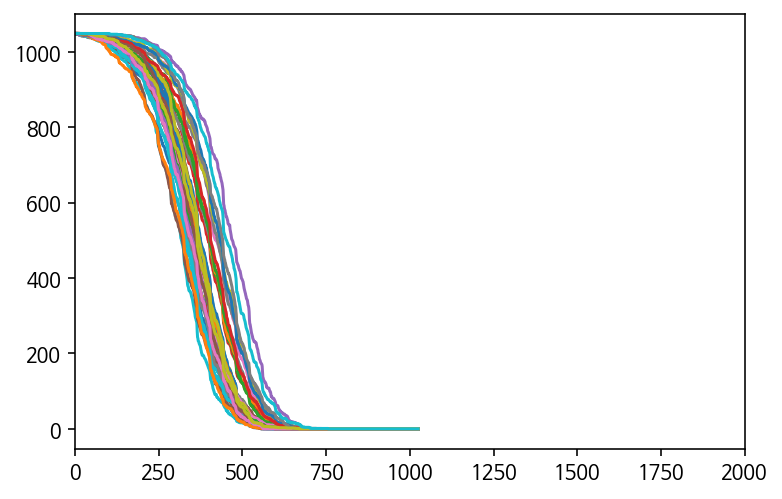

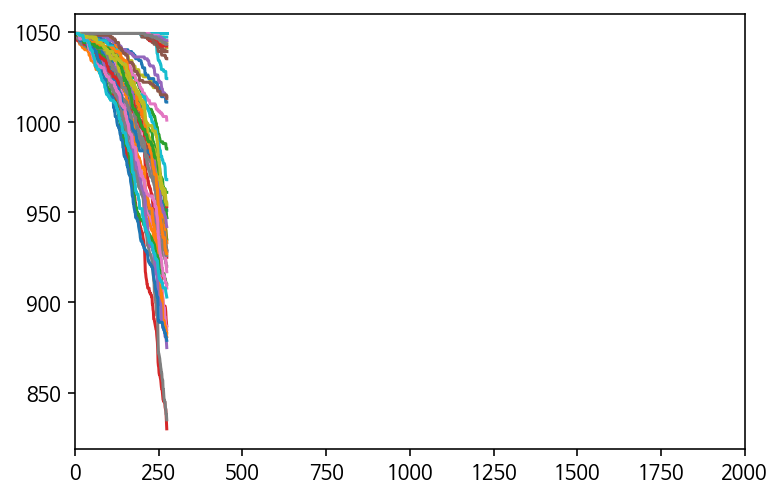

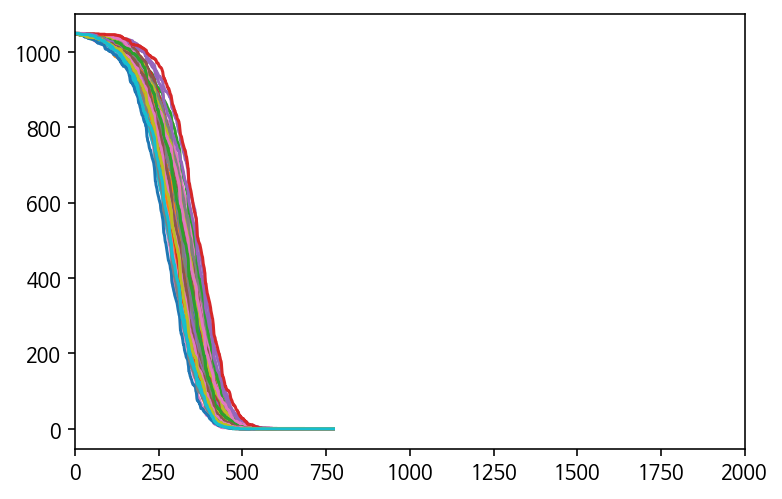

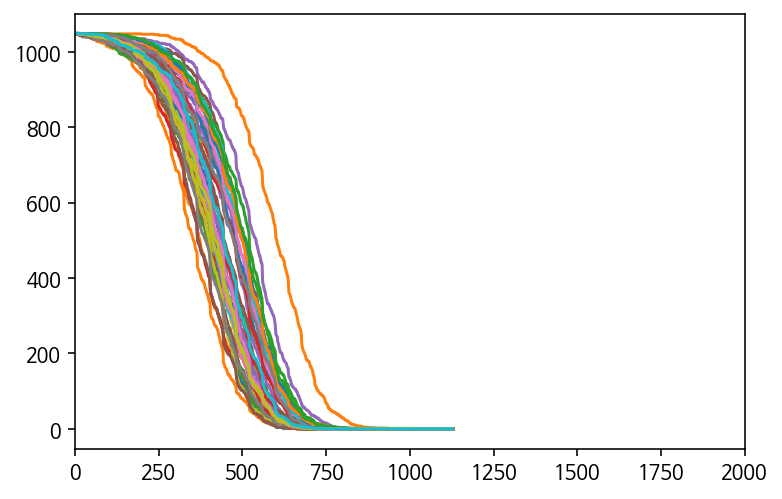

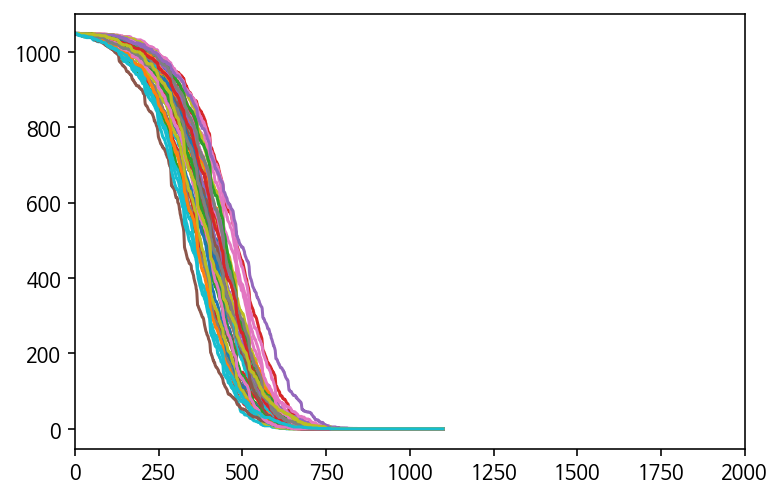

In [21]:
combine_same_hypothesis('대조군')
combine_same_hypothesis('1번')
combine_same_hypothesis('2번')
combine_same_hypothesis('3번')
combine_same_hypothesis('4번')

In [ ]:
average_IER('대조군', 37)  #  37은 하루가 37스텝임을 의미
average_IER('1번', 37)  #  37은 하루가 37스텝임을 의미
average_IER('2번', 25)  #  25은 하루가 25스텝임을 의군
average_IER('3번', 37)  #  37은 하루가 37스텝임을 의미
average_IER('4번', 37)  #  37은 하루가 37스텝임을 의미

In [ ]:
combine_averages()